# exp002

In [1]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [2]:
exp_name = 'exp002'
memo = 'baseline(N_NEIGHBORS=20)'

In [3]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import itertools
from tqdm import tqdm
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import multiprocessing
import Levenshtein
import difflib
import pickle
%load_ext Cython

In [4]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'

In [5]:
# CONFIG
SEED = 42
N_NEIGHBORS = 20
N_SPLITS = 5
PROB_TH = 0.5

In [6]:
def preprocess(df):
    columns = ['id', 'name', 'address', 'city', 'state',
        'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
    return df

In [7]:
def extract_candidate(df):
    dfs = []
    candidates = pd.DataFrame()
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df['d_near'] = dists[:, :k].tolist()
        dfs.append(country_df[['id','match_id','d_near']])
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [8]:
def add_orgin_data(df, org_df):
    df = df.explode(['match_id','d_near'])
    df = df.loc[df['id'] != df['match_id']].copy()
    df = df.merge(org_df, on='id')
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [9]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [10]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [11]:
def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
               'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[f"{c}", f"match_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"match_{c}_gesh"] = geshs
        df[f"match_{c}_leven"] = levens
        df[f"match_{c}_jaro"] = jaros
        df[f"match_{c}_lcs"] = lcss
            
        if not c in ['country', "phone", "zip"]:
            df[f"match_{c}_len"] = df[f"match_{c}"].astype(str).map(len)
            df[f"match_{c}_nleven"] = df[f"match_{c}_leven"] / df[f"match_{c}_len"]
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_lcs"] / df[f"match_{c}_len"]
    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [12]:
def reduce_data_size(df, features):
    df[features] = df[features].astype(np.float16)
    for _ in range(5):
        gc.collect()
    return df

In [13]:
def train_model(df, features):
    params = {
     'objective': 'binary',
     'boosting': 'gbdt',
     'learning_rate': 0.1,
     'metric': 'binary_logloss',
     'seed': SEED
    }

    # split folds
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(df, df["target"], df["target"])):
        df.loc[val_idx, "fold"] = i
    
    fi = pd.DataFrame()
    oof = df[['id', 'match_id', 'target']].copy()
    oof['prob'] = 0.0
    scores = []

    for i in range(N_SPLITS):
        print('fold : ' + str(i))
        tr_idx = df[df['fold'] != i].index
        vl_idx = df[df['fold'] == i].index
        tr_x, tr_y = df.loc[tr_idx, features], df.loc[tr_idx, 'target']
        vl_x, vl_y = df.loc[vl_idx, features], df.loc[vl_idx, 'target']
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=20000, early_stopping_rounds=100, verbose_eval=1000)

        # 特徴量重要度
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name()
        fi_tmp['importance'] = model.feature_importance(importance_type='gain')
        fi_tmp['iter'] = i
        fi = fi.append(fi_tmp)

        pred = model.predict(vl_x, num_iteration=model.best_iteration)
        oof.loc[vl_idx, 'prob'] = pred

        score = accuracy_score((pred > PROB_TH).astype(int), vl_y)
        scores.append(score)
        print(f'fold{i} | accuracy = ' + '{:.5f}'.format(score))

        with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
            pickle.dump(model, f)
        
    oof.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

    print('accuracy(mean) : ' + '{:.5f}'.format(np.mean(scores)))
    print(scores)

    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

    return oof, np.mean(scores)

In [14]:
def model_inference(df, features):
    pred = np.zeros(len(df))
    for i in range(N_SPLITS):
        with open(MODEL_DIR + f'model{i}.pickle', 'rb') as f:
            model = pickle.load(f)
        pred += model.predict(df[features], num_iteration=model.best_iteration) / N_SPLITS
    return pred

In [15]:
def transform_data(df, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()

    train_match = df[df['prob'] >= PROB_TH].copy()
    train_match = train_match.groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    return train_candidate[['id', 'matches']]


In [16]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

In [17]:
def run_train():
    train_origin = pd.read_csv(INPUT_DIR + "train.csv")
    train_origin = preprocess(train_origin)

    # trainデータの分割
    kf = GroupKFold(n_splits=2)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
        train_origin.loc[val_idx, "set"] = i

    # 1st stage
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0]), 
        extract_candidate(train_origin[train_origin["set"]==1]), 
    ])
    train = add_orgin_data(train, train_origin)
    stage1_max_score = calc_max_score(train, train_origin)

    # 2nd stage
    # create target
    train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)
    train["target"] = train["target"].fillna(0)

    train = add_distance_features(train)

    not_use_cols = ['match_state_leven', 'address', 'categories', 'point_of_interest', 'match_address_leven',
                    'city', 'match_point_of_interest', 'match_name', 'match_categories_leven', 'match_longitude',
                    'target', 'match_city_leven', 'zip', 'match_categories', 'match_city', 'match_latitude',
                    'match_zip', 'match_url', 'id', 'match_set', 'country', 'match_state', 'match_address',
                    'match_name_leven', 'match_id', 'latitude', 'url', 'set', 'name', 'phone', 'longitude',
                    'match_url_leven', 'state', 'match_phone', 'match_country']
    features = [c for c in train.columns if c not in not_use_cols]
    with open(OUTPUT_DIR + f'{exp_name}/features.pickle', 'wb') as f:
        pickle.dump(features, f)

    train = reduce_data_size(train, features)

    oof, stage2_mean_accuracy = train_model(train, features)
    oof = transform_data(oof, train_origin)

    cv_score = get_score(oof, train_origin)
    print(f'cv_score = ' + '{:.5f}'.format(cv_score))

    oof = postprocess(oof)
    cv_score_after_pp = get_score(oof, train_origin)
    print(f'cv_score(after_pp) = ' + '{:.5f}'.format(cv_score_after_pp))


    report = f'{exp_name}\n'
    report += memo + '\n'
    report += 'stage1_max_score : ' + '{:.5f}'.format(stage1_max_score) + '\n'
    report += 'stage2_mean_accuracy : ' + '{:.5f}'.format(stage2_mean_accuracy) + '\n'
    report += 'cv_score : ' + '{:.5f}'.format(cv_score) + '\n'
    report += 'cv_score_after_pp : ' + '{:.5f}'.format(cv_score_after_pp) + '\n'
    print(report)
    line_notify.send(report)
    slack_notify.send(report)

In [18]:
def run_inference():
    test_origin = pd.read_csv(INPUT_DIR + "test.csv")
    test_origin = preprocess(test_origin)

    # 1st stage
    test = extract_candidate(test_origin)

    # 2nd stage
    test = add_orgin_data(test, test_origin)
    test = add_distance_features(test)
    with open(MODEL_DIR + 'features.pickle', 'rb') as f:
        features = pickle.load(f)
    test = reduce_data_size(test, features)
    test['prob'] = model_inference(test, features)
    test = transform_data(test, test_origin)
    test = postprocess(test)
    test.to_csv('submission.csv', index=False)

100%|██████████| 211/211 [00:58<00:00,  3.58it/s]


1st_stage_max_score : 0.91309


213it [29:07,  8.20s/it] 


fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 670255, number of negative: 16631952
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.703469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7242
[LightGBM] [Info] Number of data points in the train set: 17302207, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038738 -> initscore=-3.211423
[LightGBM] [Info] Start training from score -3.211423
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0517311	valid_1's binary_logloss: 0.0532128
fold0 | accuracy = 0.98161
fold : 1


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 670370, number of negative: 16631837
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.647706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7224
[LightGBM] [Info] Number of data points in the train set: 17302207, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038745 -> initscore=-3.211244
[LightGBM] [Info] Start training from score -3.211244
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.0511819	valid_1's binary_logloss: 0.0524589
fold1 | accuracy = 0.98183
fold : 2


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 670047, number of negative: 16632160
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 17302207, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038726 -> initscore=-3.211746
[LightGBM] [Info] Start training from score -3.211746
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0519528	valid_1's binary_logloss: 0.0530803
fold2 | accuracy = 0.98150
fold : 3


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 671219, number of negative: 16630988
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.694118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7218
[LightGBM] [Info] Number of data points in the train set: 17302207, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038794 -> initscore=-3.209928
[LightGBM] [Info] Start training from score -3.209928
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.052226	valid_1's binary_logloss: 0.0527821
fold3 | accuracy = 0.98157
fold : 4


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 670293, number of negative: 16631915
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.458739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7167
[LightGBM] [Info] Number of data points in the train set: 17302208, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038740 -> initscore=-3.211364
[LightGBM] [Info] Start training from score -3.211364
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.0518792	valid_1's binary_logloss: 0.0527791
fold4 | accuracy = 0.98166
accuracy(mean) : 0.98163
[0.9816076653338117, 0.9818349195663351, 0.981496465653401, 0.9815685951758296, 0.9816603711295971]
cv_score = 0.81399


100%|██████████| 1138812/1138812 [00:00<00:00, 1164213.55it/s]


cv_score(after_pp) = 0.81865
exp002
baseline(N_NEIGHBORS=20)
stage1_max_score : 0.91309
stage2_mean_accuracy : 0.98163
cv_score : 0.81399
cv_score_after_pp : 0.81865



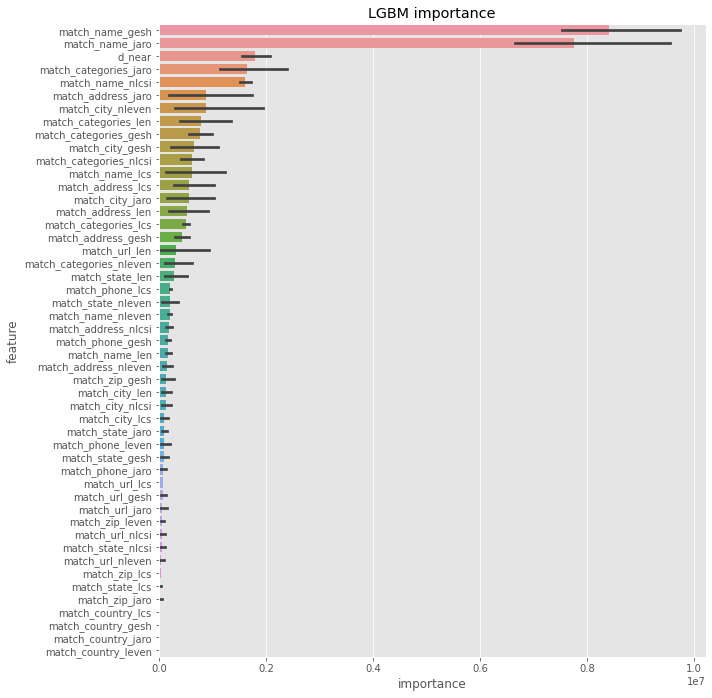

In [19]:
if MODE == 'local_train':
    run_train()
elif MODE == 'kaggle_inference':
    run_inference()